In this notebook we will download a dataset of captcha images and go through the whole process of splitting it into training and test sets, extracting the digits, labeling the ones from the training set, training a model that can succesfully learn to identify the digits, and then use this model for identifying the whole captcha images of the test set.

First of all let's import all the packages we'll use:

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import imutils
from imutils import paths
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from google.colab import files, drive
%reload_ext tensorboard

# 1. Images download and preprocessing
In this first section, we will download the dataset of captchas from Kaggle, split it into training and testing sets, and visualize one image to get a grasp of the problem that we are tackling.

First of all, let's download and unzip the dataset: 

In [2]:
# download the databaste vulnerable-captchas from kaggle:
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d electrototo/vulnerable-captchas
! mkdir input
! unzip vulnerable-captchas.zip -d input

Saving kaggle.json to kaggle.json
  0% 0.00/5.74M [00:00<?, ?B/s]
100% 5.74M/5.74M [00:00<00:00, 53.0MB/s]
Archive:  vulnerable-captchas.zip
  inflating: input/Captcha Dataset/labeled/2/1011.png  
  inflating: input/Captcha Dataset/labeled/2/1017.png  
  inflating: input/Captcha Dataset/labeled/2/1056.png  
  inflating: input/Captcha Dataset/labeled/2/1080.png  
  inflating: input/Captcha Dataset/labeled/2/1182.png  
  inflating: input/Captcha Dataset/labeled/2/1259.png  
  inflating: input/Captcha Dataset/labeled/2/1288.png  
  inflating: input/Captcha Dataset/labeled/2/1358.png  
  inflating: input/Captcha Dataset/labeled/2/1362.png  
  inflating: input/Captcha Dataset/labeled/2/1399.png  
  inflating: input/Captcha Dataset/labeled/2/222.png  
  inflating: input/Captcha Dataset/labeled/2/240.png  
  inflating: input/Captcha Dataset/labeled/2/265.png  
  inflating: input/Captcha Dataset/labeled/2/296.png  
  inflating: input/Captcha Dataset/labeled/2/346.png  
  inflating: input/Captc

In [4]:
base_path = "/content/input/Captcha Dataset/original"
image_paths = list(paths.list_images(base_path))
print("There are {} captcha images.".format(len(image_paths)))

There are 362 captcha images.


We have 362 captcha images, and each image has 4 digits in it.
This is a very low number of images for using deep learning approach (we should aim to have, as a general rule of thumb, between 1,000 and 5,000 images **per class**), so later on we will have to use some tricks and advanced strategies. Let's split the dataset into training and test sets:

In [5]:
images = [cv2.imread(path) for path in image_paths]

train = images[:326]
test = images[326:]

We create the list of images and leave the last 36 for testing (approx 10%). When our model is trained, we will create a function that, given a whole captcha image, is able to tell us the digits it contains (with some level of accuracy). 


Now let's see how our captcha images look like. Since OpenCV reads our image in the BGR format, we first transform it to RGB so plt.imshow() can plot it.

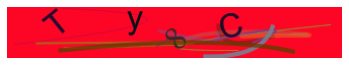

In [ ]:
def get_random_images(n):
    random_images = []
    for i in range(n):
        random_image = train[np.random.randint(len(train))]
        random_images.append(random_image)
    return random_images    

np.random.seed(42)
random_image = get_random_images(1)[0]

# change the channels format from BGR to RGB
random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
fig = plt.figure()
plt.axis("off")
plt.imshow(random_image)
plt.show()

# 2. Digit extraction and labeling

We will try to extract the digits from the captcha images and label them, so we can use them to train a convolutional neural network. Let's plot some random captcha images to try to find some patterns:

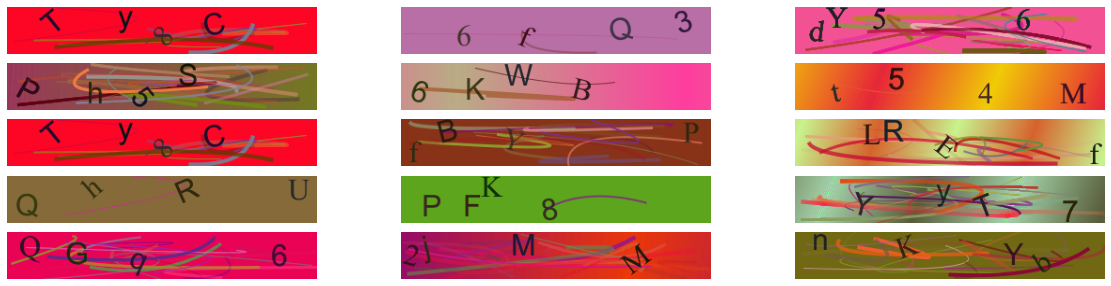

In [ ]:
np.random.seed(42)
fig = plt.figure(figsize=(20,5))
for i, image in enumerate(get_random_images(15)):
    plt.subplot(5, 3, i+1)
    plt.axis("off")
    # change the channels format from BGR to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
#plt.tight_layout()
plt.show()

We clearly see that the digits are usually much darker than the background. Hence, we will try to apply a threshold to the images (after converting them to grayscale):

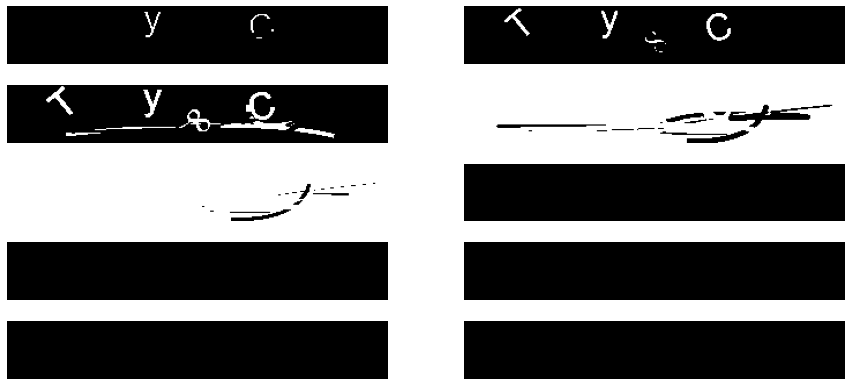

In [ ]:
np.random.seed(42)
image = get_random_images(1)[0]
# convert the images to grayscale in order to apply a threshold
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fig = plt.figure(figsize=(15,7))

# apply thresholds of 20, 45, 60... and plot them to see which range works best
for i, threshold in enumerate(range(20, 255, 25)):
    thresh = cv2.threshold(gray_image, threshold, 255, cv2.THRESH_BINARY_INV)[1]
    plt.subplot(5, 2, i+1)
    plt.axis("off")
    plt.imshow(thresh, cmap="gray")
plt.show()

We don't seem to get very good results, so we are going to try a more powerful technique: let's convert the images to HSV first, and threshold the Value channel:

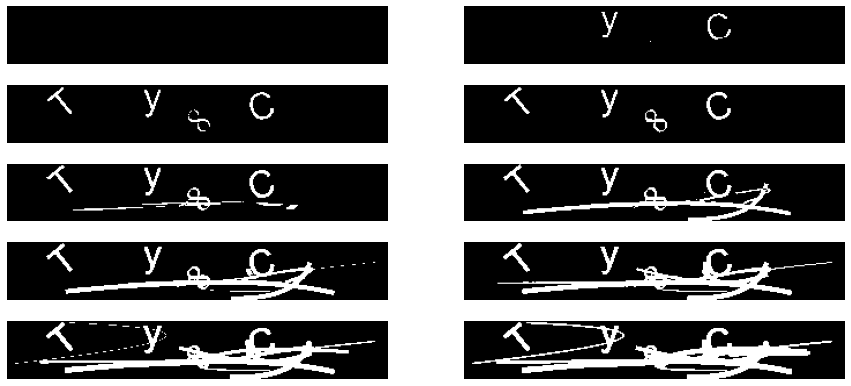

In [ ]:
np.random.seed(42)
image = get_random_images(1)[0]

# convert the image from BGR to HSV format
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#select the Value channel
v_channel = cv2.split(hsv_image)[2]
fig = plt.figure(figsize=(15,7))

# apply thresholds of 20, 45, 60... and plot them to see which range works best
for i, threshold in enumerate(range(20, 255, 25)):
    thresh = cv2.threshold(v_channel, threshold, 255, cv2.THRESH_BINARY_INV)[1]
    plt.subplot(5, 2, i+1)
    plt.axis("off")
    plt.imshow(thresh, cmap="gray")
plt.show()

We can clearly see that this approach works better for this problem. Now, we'll try to find the optimum value of the threshold to use. Let's first define a function for doing the thresholding:

In [15]:
# convert image to HSV and apply a threshold
def apply_value_threshold(image, threshold):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = cv2.split(hsv_image)[2]
    thresh = cv2.threshold(v_channel, threshold, 255, cv2.THRESH_BINARY_INV)[1]
    return thresh

We will exclude values from 0 to 50 and from 200 to 255 in our search because they didn't work very well in the last experiment.

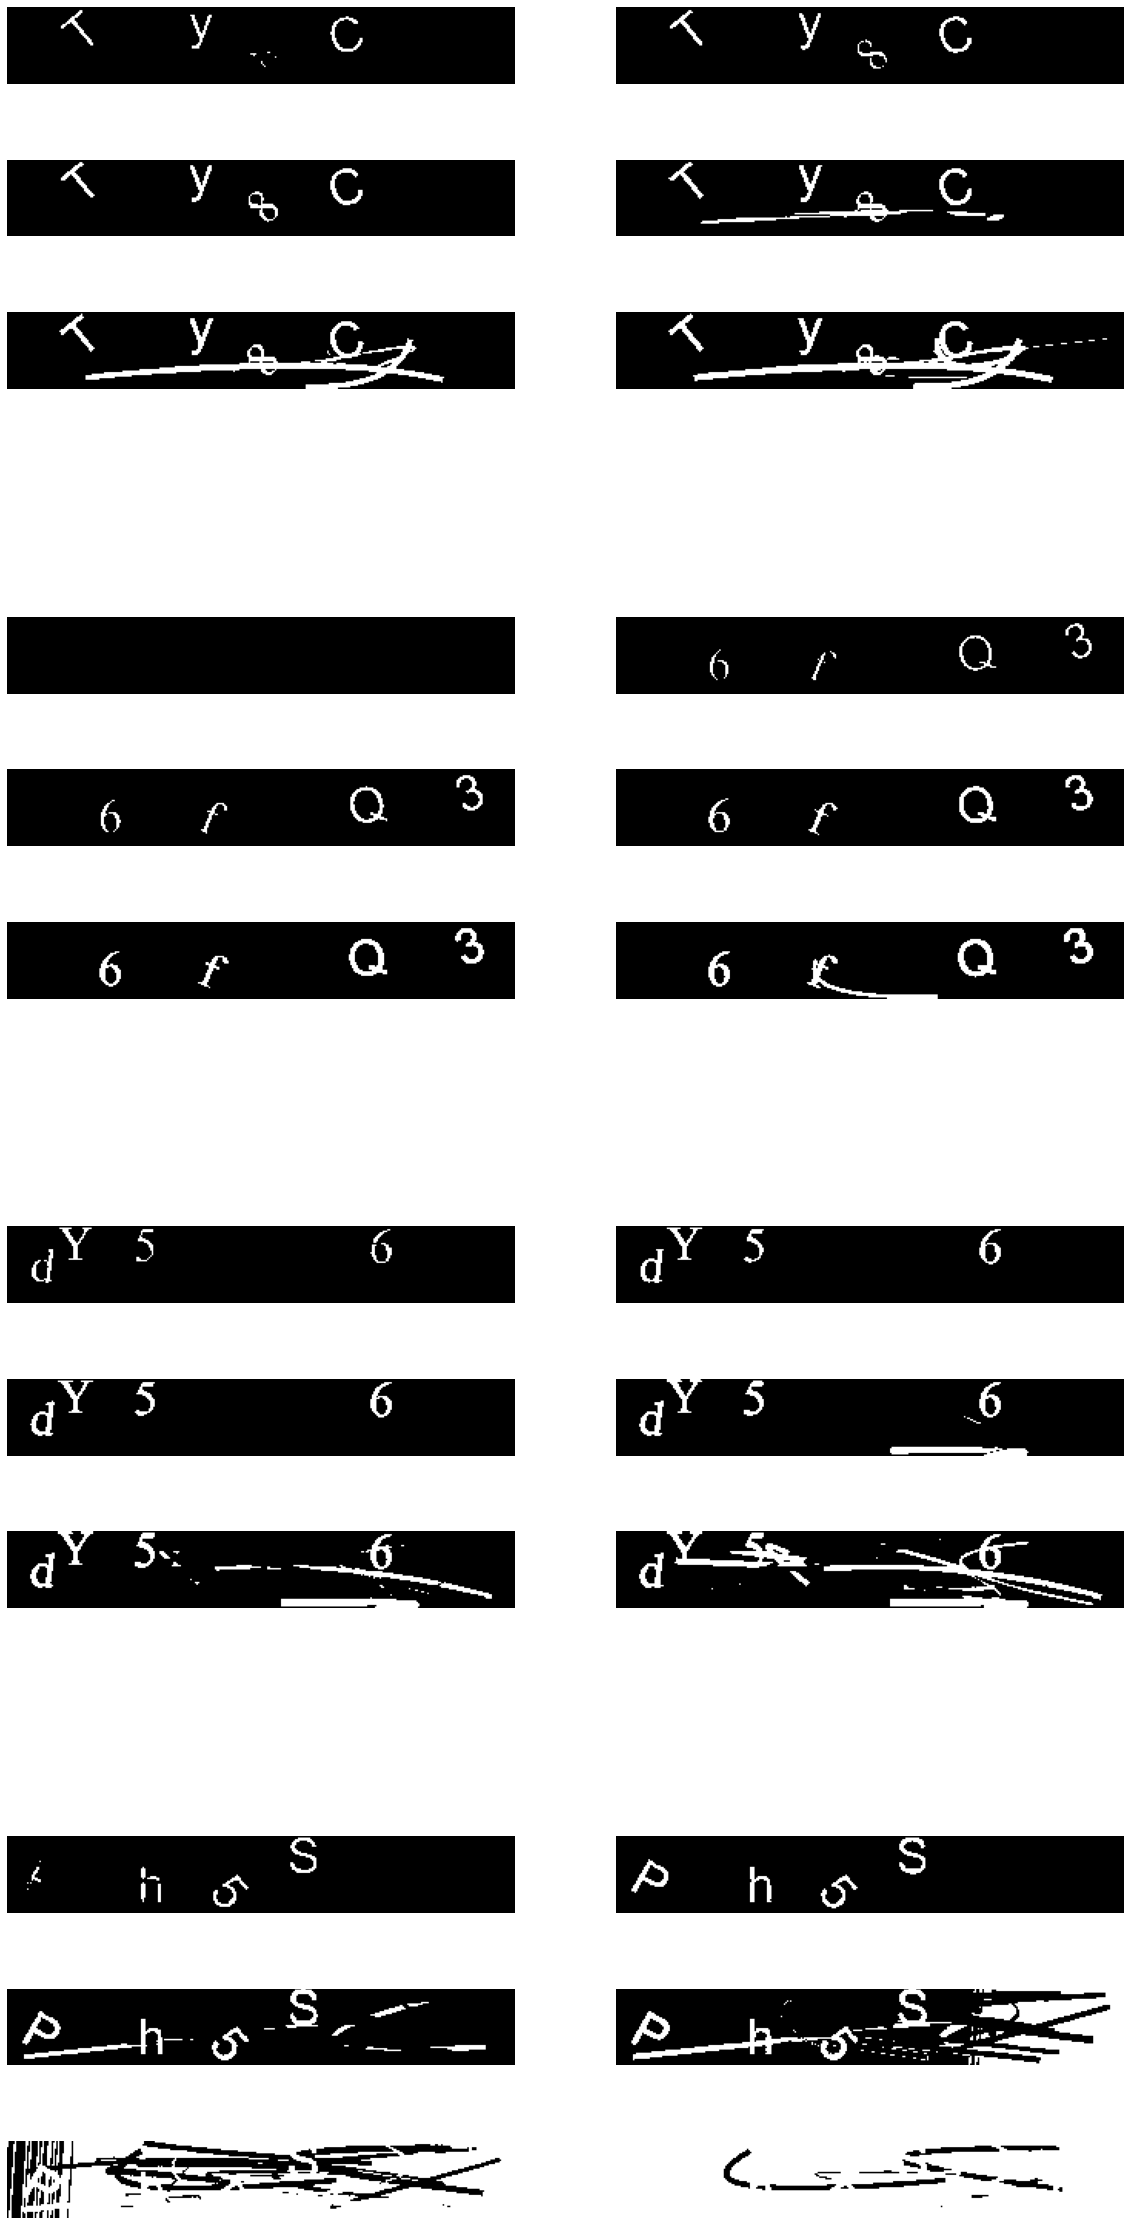

In [ ]:
np.random.seed(42)

# get 4 random images
random_images = get_random_images(4)
fig = plt.figure(figsize=(20,50))

# for each of the 4 images, apply thresholds of 20, 45, 60... and plot them to 
# see which range works best
for i, image in enumerate(random_images):
    for j, threshold in enumerate(range(50, 200, 25)):
        thresh = apply_value_threshold(image, threshold)
        # plot the thresholds so there's a white space between thresholds of
        # different images
        plt.subplot(18, 2, 8*(i+1)+j-1)
        plt.axis("off")
        plt.imshow(thresh, cmap="gray")

We can see that the third image is usually the easiest to read, and since it applies a threshold of 100, we'll search again for a range of values between 90 and 110:

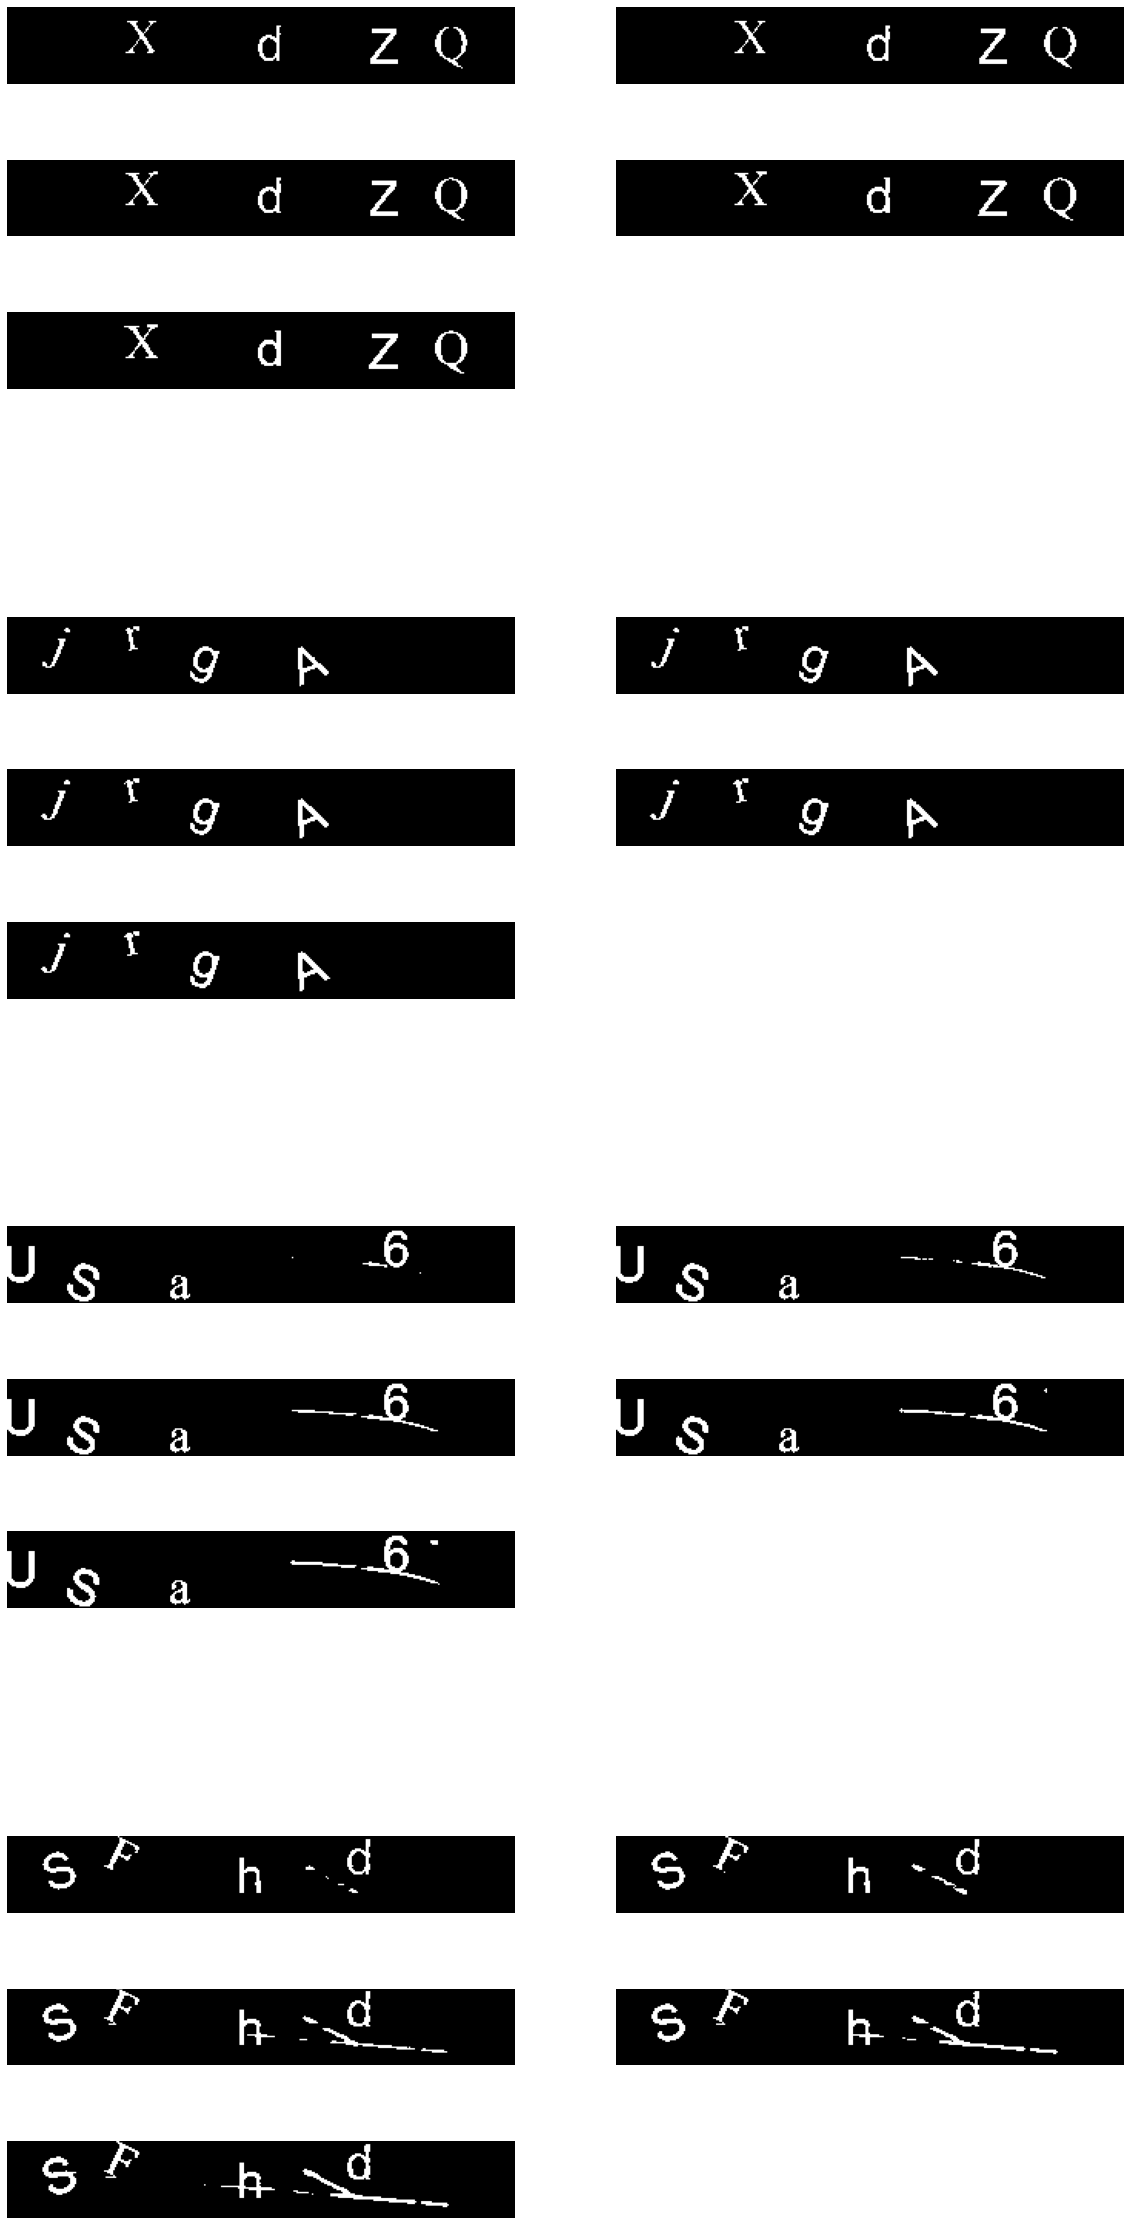

In [ ]:
# try another seed so we don't overadjust to our 4 random images
np.random.seed(43)

# get 4 random images
random_images = get_random_images(4)
fig = plt.figure(figsize=(20,50))

# for each of the 4 images, apply thresholds of 20, 45, 60... and plot them to 
# see which range works best
for i, image in enumerate(random_images):
    for j, threshold in enumerate(range(90, 115, 5)):
        thresh = apply_value_threshold(image, threshold)
        # plot the thresholds so there's a white space between thresholds of
        # different images
        plt.subplot(18, 2, 8*(i+1)+j-1)
        plt.axis("off")
        plt.imshow(thresh, cmap="gray")

Most of them are very easy to read, but we could say that the second image for each captcha is probably the easiest to recognize, so we **will use a threshold value of 95**. Let's define a function that performs the digit extraction:

In [12]:
def extract_digits(image, threshold=95, width_threshold = 6, height_threshold = 6):
    
    # initialize the list and number of digits extracted
    digits = []
    digits_appended = 0
    
    # pad the image so the digits caught in the border
    # of the image are retained
    image = cv2.copyMakeBorder(image, 2, 2, 2, 2, cv2.BORDER_REPLICATE)

    # threshold the image so the digits are easy to
    # distinguish
    thresh = apply_value_threshold(image, threshold)
    
    # find the contours of the image, keeping only
    # the four largest ones, which we assume are the digits
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    #cnts.sort(key = lambda c : c[0][0][0])
    
    # find the bounding boxes of each digit
    for c in cnts:
      (x, y, w, h) = cv2.boundingRect(c)
      if w > width_threshold and h > height_threshold and digits_appended < 4:
        # we expand the bounding box 4 pixels each dimension
        # so the digits are easier to recognize
        roi = thresh[y  : y  + h, x  : x  + h]
        if 0 not in roi.shape:
          digits.append([roi, x])
          digits_appended += 1
        else: continue
      else:
        continue
    digits.sort(key = lambda d : d[1])
    digits = [digit[0] for digit in digits]
    return digits

Let's see how successful is our function:

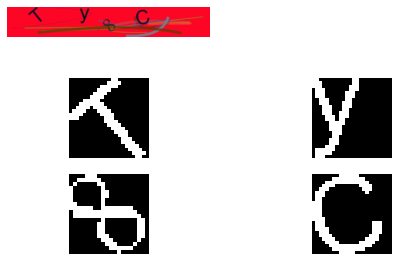

In [ ]:
np.random.seed(42)
image = get_random_images(1)[0]
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# extract the digits
digits = extract_digits(image)

# plot the digits and the image
fig = plt.figure(figsize=(8,5))
plt.subplot(3, 2, 1)
plt.axis("off")
plt.imshow(rgb_image)
for i, digit in enumerate(digits):
    plt.subplot(3, 2, i + 3)
    plt.axis("off")
    plt.imshow(digit, cmap="gray")
plt.show()

It works! Our function succesfully extracts the right digits from the image. Next, we are going to extract all digits from the training images, manually label them, and store them. I stored them in my google drive account (this notebook was ran on colab) following the structure digits/class/counts.

In [ ]:
# initialize the dictionary that will store how many images of each class we have
counts = {}

# allow to save content on google drive
drive.mount('/content/gdrive')

for image in train:
  # extract the digits
  digits = extract_digits(image)

  rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  for digit in digits:
    # show the whole image so uppercase is easier to distinguish
    plt.imshow(rgb_image)
    plt.show()

    # show each digit so I can label it
    plt.imshow(digit, cmap="gray")
    plt.show()

    # let me label the digit
    letter = input('Please type the digit: ')

    # if I don't recognize the digit, don't label it
    if letter == '?':
      continue
    if letter == 'break':
      break
    
    # update the counts dictionary
    if letter in counts.keys():
      counts[letter] += 1
    else:
      counts[letter] = 1

    # create the directory if it doesn't exist, else store the image
    digits_path = '/content/gdrive/MyDrive/digits'
    path = os.path.sep.join([digits_path, letter, '{}.png'.format(str(counts[letter]))])
    if not os.path.exists(os.path.sep.join([digits_path, letter])):
      os.makedirs(os.path.sep.join([digits_path, letter]))
    plt.imsave(path, digit)

I ran this script and manually labeled each digit image.

# 3. Digits preprocessing

Now that we have our digits extracted, labeled, and stored, let's upload and unzip their folder:

In [82]:
os.makedirs('digits_images')
! unzip digits_images.zip -d digits_images

Archive:  digits_images.zip
  inflating: digits_images/digits/b/17.png  
  inflating: digits_images/digits/b/16.png  
  inflating: digits_images/digits/b/14.png  
  inflating: digits_images/digits/b/15.png  
  inflating: digits_images/digits/b/13.png  
  inflating: digits_images/digits/B/20.png  
  inflating: digits_images/digits/B/10(1).png  
  inflating: digits_images/digits/b/18.png  
  inflating: digits_images/digits/b/5.png  
  inflating: digits_images/digits/B/9(1).png  
  inflating: digits_images/digits/B/15(1).png  
  inflating: digits_images/digits/B/22.png  
  inflating: digits_images/digits/B/13(1).png  
  inflating: digits_images/digits/b/4.png  
  inflating: digits_images/digits/b/3.png  
  inflating: digits_images/digits/B/12(1).png  
  inflating: digits_images/digits/b/12.png  
  inflating: digits_images/digits/b/10.png  
  inflating: digits_images/digits/B/14(1).png  
  inflating: digits_images/digits/B/18(1).png  
  inflating: digits_images/digits/b/7.png  
  inflating

In [83]:
digits_base_path = "/content/digits_images"
digit_paths = list(paths.list_images(digits_base_path))
print(len(digit_paths))

1236


Since some of the digits were discarded due to bad quality image issues (and we only had a handful of captcha images) we have just a few samples for each class, so we will perform data augmentation, and compare the performance we get depending on wether we use it. First of all let's preprocess the images:

In [84]:
for path in digit_paths[:10]:
  digit = cv2.imread(path)
  print(digit.shape)

(29, 12, 3)
(23, 23, 3)
(54, 54, 3)
(54, 54, 3)
(26, 26, 3)
(27, 27, 3)
(21, 21, 3)
(54, 54, 3)
(23, 23, 3)
(16, 16, 3)


Just looking at the first 10 images, we can see that they don't have a fixed shape. Since our neural network will need that they all have the same size, we'll reshape them:

In [85]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w*r), height)
    else:
        r = width / float(w)
        dim = (width, int(h*r))

    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

def preprocess(image, width, height):
    
    (h, w) = image.shape[:2]
    # first of all, resize the image so that the larger
    # dimension matches the desired dimension:
    try:
        if h > w:
            image = resize(image, height=height)
        else:
            image = resize(image, width=width)
    
    # then, pad the image along the shorter dimension.
    # number of pads needed in each side of the shorter 
    # dimension:
        padW = (width - image.shape[1]) // 2
        padH = (height - image.shape[0]) // 2
    
    # apply padding:
        image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    
    # resize again in case the padding needed wasn't
    # an integer:
        image = cv2.resize(image, (width, height))
        return image
    except:
        print("Error, initial dimensions: height:{}, width:{}".format(h,w))
    

In [86]:
# initialize the preprocessed images' list:
data= []
images = []
labels = []
for path in digit_paths:
    try:
        # because of the way I stored the images, we can access the labels
        # from the path of the image
        label = path.split(os.path.sep)[-2]
        labels.append(label)
        
        # preprocess the images:
        digit = cv2.imread(path)   
        digit = cv2.cvtColor(digit, cv2.COLOR_BGR2GRAY)     
        digit = preprocess(digit, 28, 28)
        
        # append the image so we can visualize it
        # before it gets preprocessed further
        images.append(digit)
        
        # finish preprocessing:
        digit = img_to_array(digit)
    
    
        # add preprocessed images to the list:
        data.append(digit)
    except:
        # some images have very few pixels and can't be preprocessed   
        print("Error, shape of the image: {}".format(cv2.imread(path).shape))

Now that all our digits have the same size let's finish preprocessing our images and labels, we will leave 20% of the data for validation.

In [87]:
data = np.array(data, dtype="float") / 255
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
(X_train, X_val, y_train, y_val) = train_test_split(data, labels, test_size=0.2,
                                                    random_state=42)

# 4. Model selection
Now that our data is fully preprocessed, let's define a few models and check their performance, so we can use the one that works best for this problem.

Let's define our first model, which we will use to get a benchmark performance. For that, we will use the LeNet architecture:

In [35]:
# define the LeNet architecture
class LeNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    #if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
    #first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5,5), padding='same', input_shape=inputShape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    #second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5,5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(BatchNormalization(axis=[1,2]))
    #set of FCL
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(BatchNormalization())
    #softmax classifier
    model.add(Dense(classes, activation='softmax'))
    return model

Now that the architecture is defined, let's instantiate our model:

In [36]:
classes = labels.shape[1]
print("We have {} classes".format(classes))
model1 = LeNet.build(width=28, height=28, depth=1, classes=classes)

opt1 = SGD()
model1.compile(loss="categorical_crossentropy", optimizer=opt1,
             metrics=["accuracy"])

We have 45 classes


Please note that we have 45 classes and approximately 1200 images. This is a very low images classes ratio, which means that we will have to use advanced techniques.

Let's show the summary the model to understand it better:

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 50)          196       
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1

We can see that it's a relatively small model. Let's see how it performs:

In [ ]:
H1 = model1.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=32,
             epochs=200)

Epoch 1/200
31/31 [==============================] - 0s 14ms/step - loss: 2.5114 - accuracy: 0.3998 - val_loss: 3.5913 - val_accuracy: 0.2056
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 1.2044 - accuracy: 0.7692 - val_loss: 3.5546 - val_accuracy: 0.0444
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.8347 - accuracy: 0.8401 - val_loss: 3.5739 - val_accuracy: 0.0081
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.6183 - accuracy: 0.8846 - val_loss: 3.5700 - val_accuracy: 0.0161
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.4666 - accuracy: 0.9251 - val_loss: 3.6242 - val_accuracy: 0.0081
Epoch 6/200
31/31 [==============================] - 0s 6ms/step - loss: 0.3539 - accuracy: 0.9514 - val_loss: 3.4779 - val_accuracy: 0.0363
Epoch 7/200
31/31 [==============================] - 0s 9ms/step - loss: 0.2769 - accuracy: 0.9686 - val_loss: 3.3520 - val_accuracy: 0.0565
Epoch 8/200


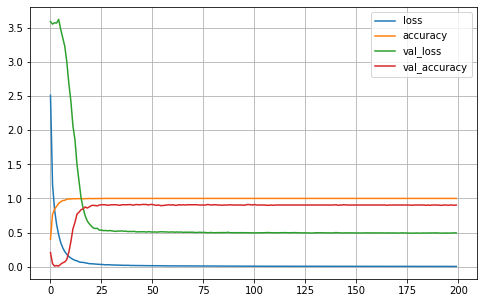

Validation accuracy of the model: 0.9032257795333862


In [ ]:
pd.DataFrame(H1.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()
print("Validation accuracy of the model: {}".format(H1.history["val_accuracy"][-1]))

This graph shows a clear overfitting, we achieve a 100% training accuracy approximately from epoch 15.
However, now we have a benchmark of the validation accuracy that we can achieve. We will use regularization thechniques and other model architectures to try to improve it:

Let's perform data augmentation, a very powerful regularization technique (specially when we don't have a lot of data), and compare the results:

In [ ]:
aug = ImageDataGenerator(rotation_range = 45, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         fill_mode="nearest")

We'll use a learning rate schedule for improving the performance:

In [ ]:
def schedule1(epoch):
  if epoch < 150:
    return 0.01
  if epoch < 300:
    return 0.001
  else:
    return 0.0005

In [ ]:
model2 = LeNet.build(width=28, height=28, depth=1, classes=classes)
opt2 = SGD(lr=0.01, momentum=0.9)
logdir_model2 = os.path.join("logs_model2", "lr=schedule1, momentum=0.9")
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=logdir_model2, histogram_freq=3)
model2.compile(loss="categorical_crossentropy", optimizer=opt2,
             metrics=["accuracy"])
callbacks2 = [tensorboard_callback2, LearningRateScheduler(schedule1)]

In [ ]:
H2 = model2.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
               steps_per_epoch=len(X_train) // 32, epochs=600, verbose=1, callbacks=callbacks2)

Epoch 1/600
30/30 [==============================] - 1s 22ms/step - loss: 3.8749 - accuracy: 0.0827 - val_loss: 13.0436 - val_accuracy: 0.0161
Epoch 2/600
30/30 [==============================] - 0s 13ms/step - loss: 2.9338 - accuracy: 0.2358 - val_loss: 9.2002 - val_accuracy: 0.0524
Epoch 3/600
30/30 [==============================] - 0s 13ms/step - loss: 2.7859 - accuracy: 0.2695 - val_loss: 3.7090 - val_accuracy: 0.0726
Epoch 4/600
30/30 [==============================] - 0s 14ms/step - loss: 2.4713 - accuracy: 0.3288 - val_loss: 3.2712 - val_accuracy: 0.1411
Epoch 5/600
30/30 [==============================] - 0s 13ms/step - loss: 2.3078 - accuracy: 0.3777 - val_loss: 2.0121 - val_accuracy: 0.4758
Epoch 6/600
30/30 [==============================] - 0s 14ms/step - loss: 2.0093 - accuracy: 0.4609 - val_loss: 7.1537 - val_accuracy: 0.0524
Epoch 7/600
30/30 [==============================] - 0s 13ms/step - loss: 1.9444 - accuracy: 0.4929 - val_loss: 10.1880 - val_accuracy: 0.0444
Epoc

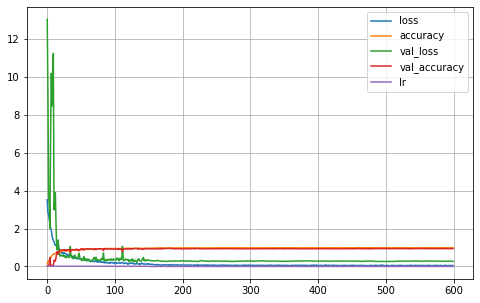

Validation accuracy of the model: 0.9395161271095276


In [ ]:
pd.DataFrame(H2.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()
print("Validation accuracy of the model: {}".format(H2.history['val_accuracy'][-1]))

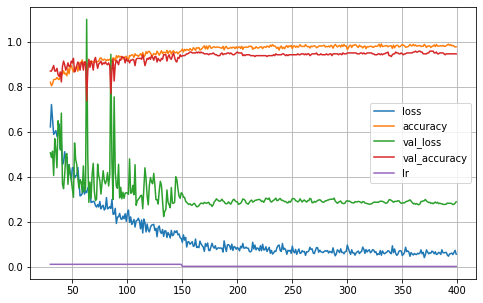

In [ ]:
pd.DataFrame(H2.history).iloc[30:].plot(figsize=(8,5))
plt.grid(True)
plt.show()

Now the gap between the validation and training accuracy is smaller, but we can see that from epoch 150 we are still overfitting: the validation loss stagnates while the training loss keeps going down. We will try to apply even more regularization techniques, in particular, weight decay and dropout. We can also see that the training accuracy doesn't reach 100%, so later we will also consider a more complex model architecture.

In [ ]:
class regularized_LeNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    #if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
    #first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5,5), padding='same', input_shape=inputShape, 
                     activation='relu', kernel_regularizer=l2()))
    model.add(BatchNormalization(axis=[1,2]))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))
    #second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5,5), padding='same', activation='relu',
                     kernel_regularizer=l2()))
    model.add(BatchNormalization(axis=[1,2]))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))
    #set of FCL
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_regularizer=l2()))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    #softmax classifier
    model.add(Dense(classes, activation='softmax'))
    return model

In [ ]:
model3 = regularized_LeNet.build(width=28, height=28, depth=1, classes=classes)
opt3 = SGD(lr=0.01, momentum=0.9)
logdir_model3 = os.path.join("logs_model3", "lr=schedule1, momentum=0.9")
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=logdir_model3, histogram_freq=3)
model3.compile(loss="categorical_crossentropy", optimizer=opt3,
             metrics=["accuracy"])
callbacks2 = [LearningRateScheduler(schedule1)]

In [ ]:
H3 = model3.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
               steps_per_epoch=len(X_train) // 32, epochs=600, verbose=1, callbacks=callbacks2)

Epoch 1/600
30/30 [==============================] - 2s 21ms/step - loss: 13.1676 - accuracy: 0.0602 - val_loss: 15.6563 - val_accuracy: 0.0605
Epoch 2/600
30/30 [==============================] - 0s 13ms/step - loss: 11.7416 - accuracy: 0.1518 - val_loss: 10.7045 - val_accuracy: 0.2218
Epoch 3/600
30/30 [==============================] - 0s 14ms/step - loss: 10.7473 - accuracy: 0.2067 - val_loss: 9.6455 - val_accuracy: 0.3306
Epoch 4/600
30/30 [==============================] - 0s 14ms/step - loss: 9.8988 - accuracy: 0.2273 - val_loss: 8.8839 - val_accuracy: 0.3145
Epoch 5/600
30/30 [==============================] - 0s 14ms/step - loss: 9.0768 - accuracy: 0.2393 - val_loss: 8.3503 - val_accuracy: 0.3024
Epoch 6/600
30/30 [==============================] - 0s 14ms/step - loss: 8.2928 - accuracy: 0.2785 - val_loss: 9.2069 - val_accuracy: 0.0968
Epoch 7/600
30/30 [==============================] - 0s 14ms/step - loss: 7.7068 - accuracy: 0.2880 - val_loss: 9.9054 - val_accuracy: 0.0323
E

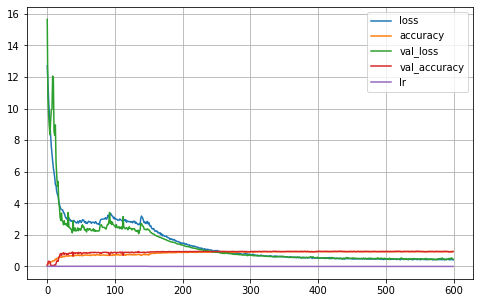

Validation accuracy of the model: 0.9435483813285828


In [ ]:
pd.DataFrame(H3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()
print("Validation accuracy of the model: {}".format(H3.history['val_accuracy'][-1]))

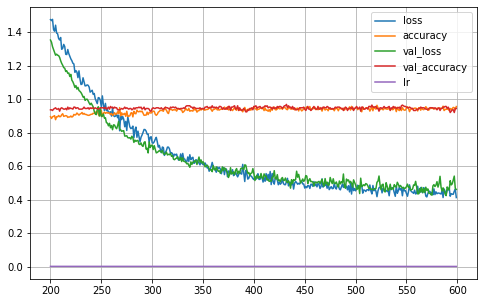

In [ ]:
pd.DataFrame(H3.history).iloc[200:].plot(figsize=(8,5))
plt.grid(True)
plt.show()

Now we get a slightly better validation accuracy, but we have regularized our model so much (and it is relatively shallow) that it doesn't perform that well on the training set, so we will try a more complex architecture:

First, of all, let's try the MiniVGGnet architecture:

In [ ]:
class MiniVGGNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    #if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    #first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3,3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3,3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    #since we don't explicitly set a stride, keras implicitly assumes
    #our stride to be equal to the max pooling size, in this case 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3,3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    #since we don't explicitly set a stride, keras implicitly assumes
    #our stride to be equal to the max pooling size, in this case 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    #set of FCL
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #softmax classifier
    model.add(Dense(classes, activation='softmax'))

    return model

In [ ]:
model4 = MiniVGGNet.build(width=28, height=28, depth=1, classes=classes)
opt4 = SGD(lr=0.01, momentum=0.9)
callbacks4 = [LearningRateScheduler(schedule1)]
model4.compile(loss="categorical_crossentropy", optimizer=opt4,
              metrics=["accuracy"])
model4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 64)      

Now, let's train it. We'll use data augmentation from the start, it doesn't hurt our model and it prevents overfitting (which would be very likely to happen):

In [ ]:
H4 = model4.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
               steps_per_epoch=len(X_train) // 32, epochs=600, verbose=1, callbacks=callbacks4)

Epoch 1/600
30/30 [==============================] - 1s 20ms/step - loss: 4.7665 - accuracy: 0.0725 - val_loss: 17.5053 - val_accuracy: 0.0484
Epoch 2/600
30/30 [==============================] - 0s 14ms/step - loss: 3.4769 - accuracy: 0.1869 - val_loss: 7.5433 - val_accuracy: 0.0524
Epoch 3/600
30/30 [==============================] - 0s 15ms/step - loss: 2.9377 - accuracy: 0.3021 - val_loss: 3.8513 - val_accuracy: 0.1573
Epoch 4/600
30/30 [==============================] - 0s 14ms/step - loss: 2.4466 - accuracy: 0.3947 - val_loss: 3.5015 - val_accuracy: 0.1452
Epoch 5/600
30/30 [==============================] - 0s 14ms/step - loss: 2.1500 - accuracy: 0.4130 - val_loss: 3.9805 - val_accuracy: 0.0685
Epoch 6/600
30/30 [==============================] - 0s 14ms/step - loss: 1.9628 - accuracy: 0.4996 - val_loss: 3.7370 - val_accuracy: 0.0847
Epoch 7/600
30/30 [==============================] - 0s 13ms/step - loss: 2.0195 - accuracy: 0.4924 - val_loss: 4.3900 - val_accuracy: 0.0927
Epoch

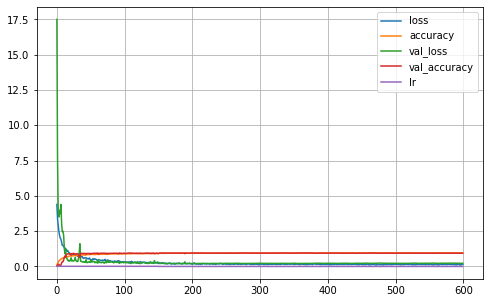

Validation accuracy of the model: 0.9395161271095276


In [ ]:
pd.DataFrame(H4.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()
print("Validation accuracy of the model: {}".format(H4.history['val_accuracy'][-1]))

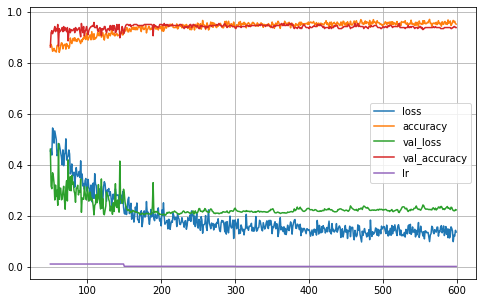

In [ ]:
pd.DataFrame(H4.history).iloc[50:].plot(figsize=(8,5))
plt.grid(True)
plt.show()

Again, although we get good results, we can see that we start overfitting approximately from epoch 200, so we will try to combat overfitting by adding stronger dropout and weight decay:

In [ ]:
class regularized_MiniVGGNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    #if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    #first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.1), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.1), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    #since we don't explicitly set a stride, keras implicitly assumes
    #our stride to be equal to the max pooling size, in this case 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    #second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.1), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.1), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    #since we don't explicitly set a stride, keras implicitly assumes
    #our stride to be equal to the max pooling size, in this case 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    #set of FCL
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(0.1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #softmax classifier
    model.add(Dense(classes, activation='softmax'))

    return model

In [ ]:
def schedule2(epoch):
  if epoch < 100:
    return 0.001
  if epoch < 200:
    return 0.0005
  if epoch < 300:
    return 0.00005
  if epoch < 400:
    return 0.00001
  else:
    return 0.000005

In [ ]:
model5 = regularized_MiniVGGNet.build(width=28, height=28, depth=1, classes=classes)
opt5 = SGD(lr=0.01, momentum=0.9)
model5.compile(loss="categorical_crossentropy", optimizer=opt5,
              metrics=["accuracy"])
callbacks5 = [LearningRateScheduler(schedule2)]

In [ ]:
H5 = model5.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
               steps_per_epoch=len(X_train) // 32, epochs=600, verbose=1, callbacks=callbacks5)

Epoch 1/600
30/30 [==============================] - 2s 22ms/step - loss: 106.0450 - accuracy: 0.0242 - val_loss: 97.7909 - val_accuracy: 0.0323
Epoch 2/600
30/30 [==============================] - 0s 15ms/step - loss: 95.9539 - accuracy: 0.0559 - val_loss: 87.4341 - val_accuracy: 0.0282
Epoch 3/600
30/30 [==============================] - 0s 14ms/step - loss: 85.0245 - accuracy: 0.1322 - val_loss: 78.1519 - val_accuracy: 0.0282
Epoch 4/600
30/30 [==============================] - 0s 15ms/step - loss: 75.5581 - accuracy: 0.1775 - val_loss: 69.9330 - val_accuracy: 0.0121
Epoch 5/600
30/30 [==============================] - 0s 15ms/step - loss: 66.9609 - accuracy: 0.2089 - val_loss: 62.7649 - val_accuracy: 0.0081
Epoch 6/600
30/30 [==============================] - 0s 14ms/step - loss: 59.5733 - accuracy: 0.2555 - val_loss: 56.3842 - val_accuracy: 0.0121
Epoch 7/600
30/30 [==============================] - 0s 15ms/step - loss: 53.0076 - accuracy: 0.3030 - val_loss: 50.8301 - val_accuracy

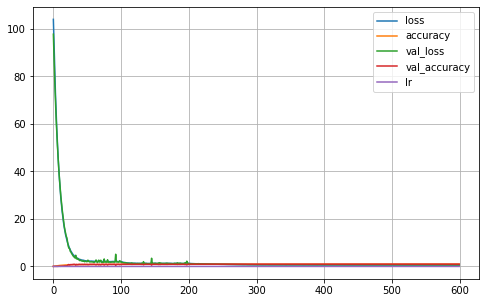

Validation accuracy of the model: 0.9677419066429138


In [ ]:
pd.DataFrame(H5.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()
print("Validation accuracy of the model: {}".format(H5.history['val_accuracy'][-1]))

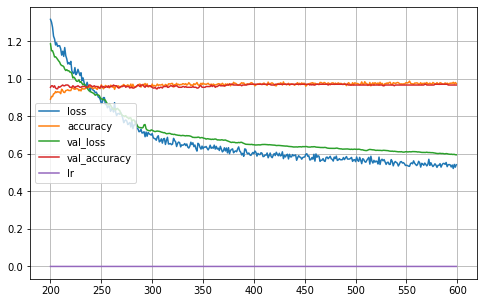

In [ ]:
pd.DataFrame(H5.history).iloc[200:].plot(figsize=(8,5))
plt.grid(True)
plt.show()

We get much better results now, and there is much less overfitting. We will try an even more complex architecture, to see if we can improve the already high training accuracy without overfitting:

In [ ]:
class extended_MiniVGGNet:
  @staticmethod
  def build(width, height, depth, classes):
    #initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    #if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
      chanDim = 1
    model.add(BatchNormalization(axis=chanDim, input_shape=inputShape))
    #first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    #since we don't explicitly set a stride, keras implicitly assumes
    #our stride to be equal to the max pooling size, in this case 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    #second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    #since we don't explicitly set a stride, keras implicitly assumes
    #our stride to be equal to the max pooling size, in this case 2x2
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    #third CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(128, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3,3), kernel_regularizer=l2(0.3), padding="same",
                     input_shape=inputShape, activation="relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    #set of FCL
    model.add(Flatten())
    model.add(Dense(1024, kernel_regularizer=l2(0.3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1024, kernel_regularizer=l2(0.3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1024, kernel_regularizer=l2(0.3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1024, kernel_regularizer=l2(0.3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    #softmax classifier
    model.add(Dense(classes, activation='softmax'))

    return model

In [ ]:
def schedule3(epoch):
  if epoch < 200:
    return 0.0005
  if epoch < 300:
    return 0.0001
  if epoch < 400:
    return 0.00005
  if epoch < 500:
    return 0.00001
  if epoch < 600:
    return 0.000005
  if epoch < 7000:
    return 0.000001
  if epoch < 9000:
    return 0.0000005
  if epoch < 1000:
    return 0.0000001
  if epoch < 1300:
    return 0.00000005
  if epoch < 1500:
    return 0.00000001

In [ ]:
model6 = extended_MiniVGGNet.build(width=28, height=28, depth=1, classes=classes)
opt6 = SGD(lr=0.001, momentum=0.9)
model6.compile(loss="categorical_crossentropy", optimizer=opt6,
              metrics=["accuracy"])
callbacks6 = [LearningRateScheduler(schedule3)]

In [ ]:
H6 = model6.fit(aug.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val),
               steps_per_epoch=len(X_train) // 32, epochs=1000, verbose=1, callbacks=callbacks6)

Epoch 1/1000
30/30 [==============================] - 3s 33ms/step - loss: 1396.3013 - accuracy: 0.0166 - val_loss: 1254.7584 - val_accuracy: 0.0202
Epoch 2/1000
30/30 [==============================] - 1s 18ms/step - loss: 1203.0820 - accuracy: 0.0255 - val_loss: 1049.3381 - val_accuracy: 0.0202
Epoch 3/1000
30/30 [==============================] - 1s 18ms/step - loss: 1004.8689 - accuracy: 0.0467 - val_loss: 874.4323 - val_accuracy: 0.0202
Epoch 4/1000
30/30 [==============================] - 1s 18ms/step - loss: 836.8642 - accuracy: 0.0621 - val_loss: 728.4526 - val_accuracy: 0.0242
Epoch 5/1000
30/30 [==============================] - 1s 19ms/step - loss: 696.6328 - accuracy: 0.0897 - val_loss: 606.8313 - val_accuracy: 0.0202
Epoch 6/1000
30/30 [==============================] - 1s 20ms/step - loss: 580.1360 - accuracy: 0.1440 - val_loss: 505.6608 - val_accuracy: 0.0161
Epoch 7/1000
30/30 [==============================] - 1s 19ms/step - loss: 483.2198 - accuracy: 0.1835 - val_loss

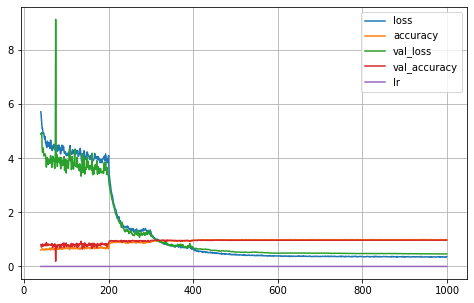

In [ ]:
pd.DataFrame(H6.history).iloc[40:].plot(figsize=(8,5))
plt.grid(True)
plt.show()

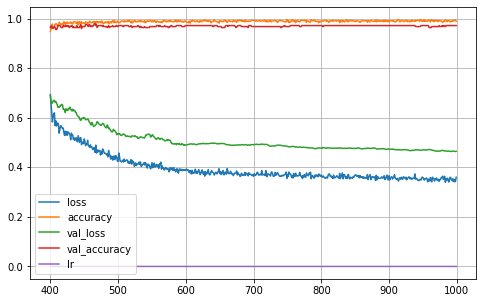

In [ ]:
pd.DataFrame(H6.history).iloc[400:].plot(figsize=(8,5))
plt.grid(True)
plt.show()

We seem to get slightly better performance than when using other architectures, so we'll choose this model. Although there's some overfitting, it's not extreme, and we can't add more regularization or the training process becomes very unstable. We'll train this model 5 times on all the training data, and we will use it for building an ensemble. This will probably enhance our performance on the testing phase:

In [ ]:
X_train_full = np.concatenate((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))
X_train_full.shape

(1236, 28, 28, 1)

In [37]:
for i in range(5):
  model6 = extended_MiniVGGNet.build(width=28, height=28, depth=1, classes=classes)
  opt6 = SGD(lr=0.001, momentum=0.9)
  model6.compile(loss="categorical_crossentropy", optimizer=opt6,
                metrics=["accuracy"])
  callbacks6 = [LearningRateScheduler(schedule3)]
  model6.fit(aug.flow(X_train_full, y_train_full, batch_size=32), 
          steps_per_epoch=len(X_train_full) // 32, epochs=1000, verbose=1,
           callbacks=callbacks6)
  model6.save("model6_{}.h5".format(str(i)))

# 5. Testing:
Now that we have our model trained 5 times, let's build a function that finds the contours and labels the image:

In [73]:
models = []
for i in range(5):
  model = load_model("/content/model6_{}.h5".format(str(i)))
  models.append(model)

In [128]:
def label_img(image):
  digits = extract_digits(image)
  predictions = []
  for digit in digits:
    try:
      # preprocess the ROI and add a dummy dimension so the network
      # can take it as input
      digit = preprocess(digit, 28, 28)
      digit = np.expand_dims(img_to_array(digit), axis=0) / 255.0
          
      # get the predicted label using and ensemble of the models
      probabilities = []
      for model in models:
        probabilities.append(model.predict(digit))
        prediction = np.average(probabilities, axis=0)

      # append the label to the list
      label = lb.inverse_transform(prediction)
      if label == 'none':
        label = ''
      predictions.append(label)
    except:
      predictions.append(" ")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.axis('off')
  captcha = ''
  for item in predictions:
    label = str(item)[2:-2]
    captcha += label + ' '
  image = cv2.putText(image, captcha, (250,15) , cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)
  plt.imshow(image)
  plt.show()

Let's show all the test images with their predicted labels:

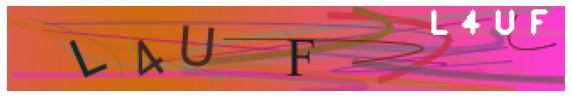

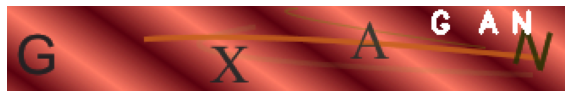

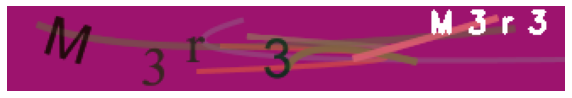

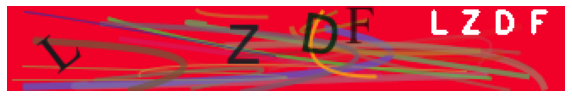

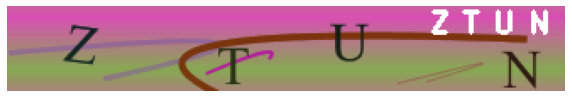

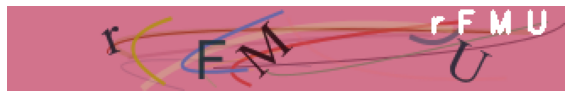

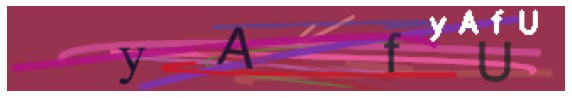

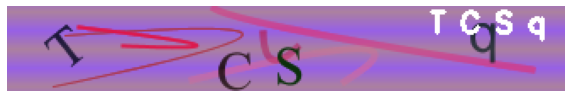

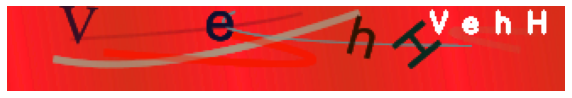

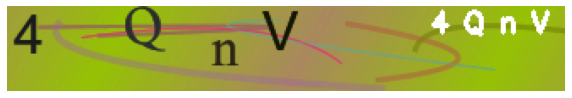

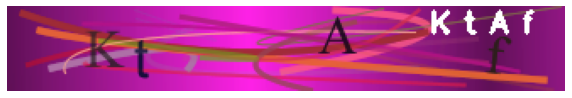

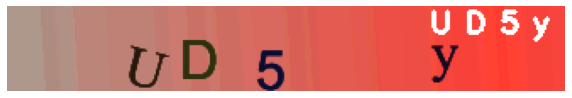

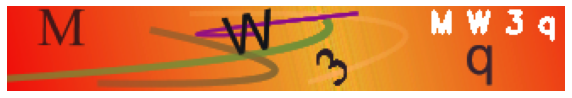

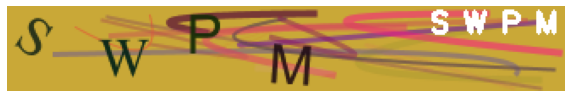

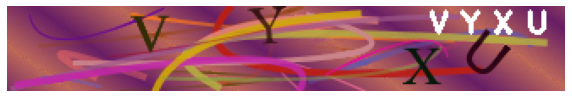

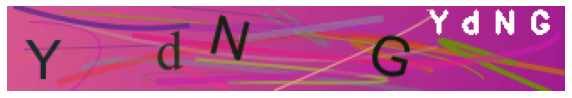

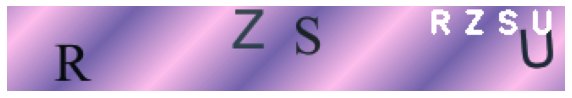

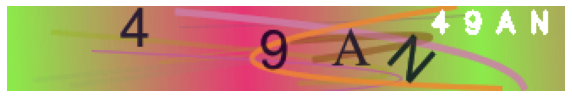

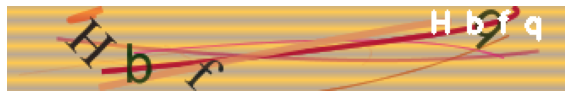

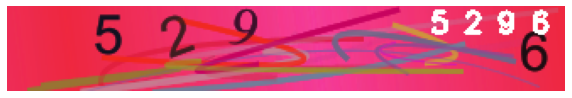

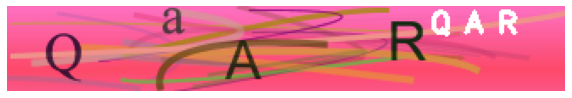

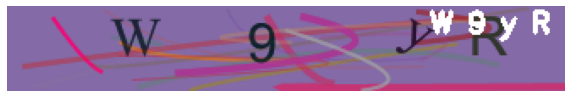

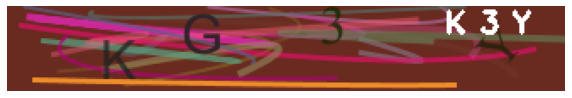

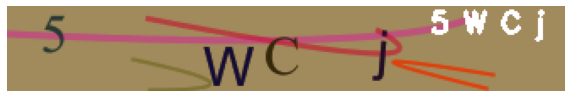

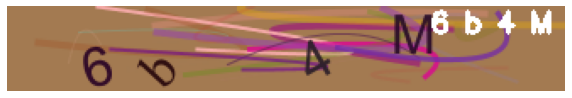

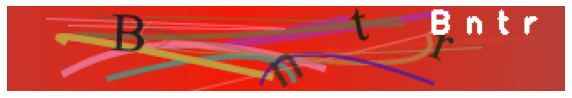

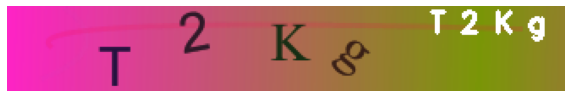

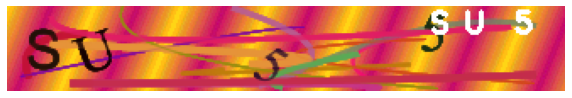

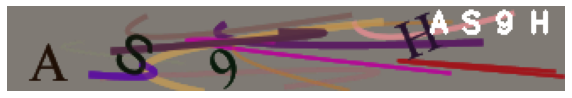

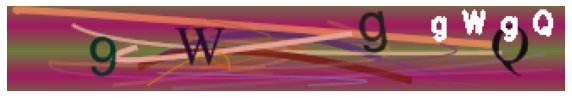

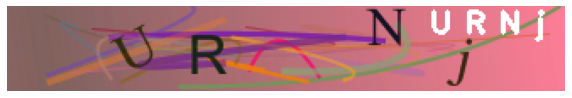

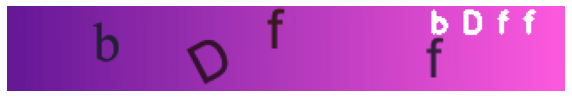

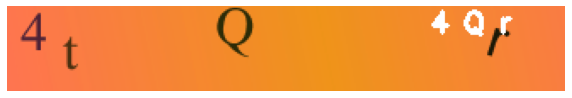

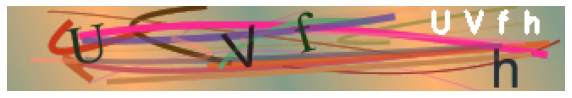

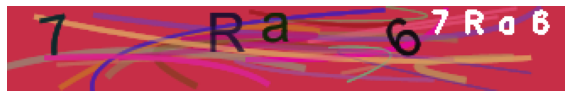

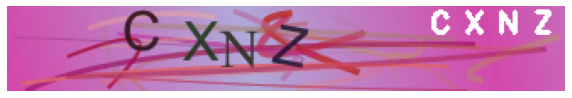

In [137]:
for image in test:
  fig = plt.figure(figsize=(10,5))
  label_img(image)

We can see that our function fails to recognize 4 digits (this is probably due to the digit extraction algorithm), but **it doesn't classify incorrectly any digit**, which taking into account that we had **45 classes and only 1236 images for training**, I think is a success.